# RBM (Restrictive Boltzmann Machine)

> Assigns lower energy values to more relevant features and higher energy values for less important features.

> **Objective**: minimize the energy value.

> **Restrictive**: because the neurons inside the same layer are not connected, but they are fully connected with the neurons in the next layer.

### Simple RBM
2 passes are performed:
- forward pass: the input to the visible layer is the input image x
- backward pass: the input the hidden layer is the probability of obtaining x with the configuration of the input features

The objective is to obtain the optimal values for the hyperparameters (weight matrix, biases) so that the reconstruction error would be minimum. SGD is used to minimize the reconstruction error and obtain a more accurate reconstruction of the input, by updating the hyperparameters after visiting each instance. (online training)

The reconstruction error is computed as the difference between the pixel-wise mean-square error of the inputs to the visible layer (original image) and the output of the reconstructed image. The mean of the reconstruction errors of each training instance represents the training loss.

### Gibbs Sampling
The learning process consists of 2 phases:
- Gibbs sampling: first, the input (v) data is sent through the visible layer (forward pass), then the states of the neurons in the hidden layer are computed (h). Based on the obtained hidden layer values, it predicts the new input values for the visible layer (backward pass).
- Contrastive Divergence: update weights based on the inputs to visible layers and the activation probabilities for the hidden layers.

To find the optimal weight W, which minimizes the energy function E (cost function), we use **SGD**(Stochastic Gradient Descent) algorithm. For this we need to compute the derivative of E with respect to v and h (visible and hidden neuron's input), which in turn gives us 2 terms, a positive and negative gradient.
Positive phase increases the probability of the training data, while the negative decreases it.

To adjust the weights we use the "Contrastive Divergence" algorithm, which build an update matrix that allows to alter incrementally the value of W.
W_new = W + learning_rate * CD

The RBM is trained through several forward and backward passes until it is able to extract the most important features/patterns.
> * **Forward pass**: input processing
> * **Backward pass**: reconstruction

### Energy based model
Computes the free energy for the initial input to the visible layer and the reconstructed input, then it defines the loss as the absolute difference between these energy values.
> **Free energy** is the energy that a single configuration would need in order to
    have the same probability as all configurations containing v

This approach also uses SGD to minimize the energy loss, which represents the difference between the free energy of the input x and the reconstructed input v.


In [490]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
%matplotlib inline
import tensorflow_datasets as tfds
import cv2
from PIL import Image
import os
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error
from sklearn import feature_extraction
import time

In [2]:
# test if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
print(tf.config.experimental.get_device_details(physical_devices[0]))
logical_devices = tf.config.list_logical_devices('GPU')
print(logical_devices)
GPU_NAME = logical_devices[0].name
print("logical GPU name = ", GPU_NAME)

{'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU', 'compute_capability': (8, 6)}
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
logical GPU name =  /device:GPU:0


## Load and preprocess the data

The model is trained and evaluated on the Lost and Found dataset, which contains over 2000 images in total, obtained from multiple video sequences. Each image has an associated segmentation mask for all classes of objects and one for distinguishing the road surface.

Save the data

In [3]:
def save_img(img_arr, file_name):
    img_arr = img_arr.astype(np.uint8)
    if img_arr.ndim == 3 and img_arr.shape[2] == 1:
        img_arr = np.squeeze(img_arr, axis=2)
    img = Image.fromarray(img_arr)
    img.save(file_name)


def save_dataset(dataset, directory):
    nr_images = dataset.shape[0]
    for i in range(nr_images):
        save_img(dataset[i], directory + "/{}.jpeg".format(i))

Download the dataset

In [511]:
def download_data():
    (lost_and_found_train_ds, lost_and_found_test_ds), info = tfds.load(
        'lost_and_found/semantic_segmentation',
        split=['train', 'test'],
        batch_size=-1,
        with_info=True)

    x_train_img = lost_and_found_train_ds['image_left']
    x_train_mask = lost_and_found_train_ds['segmentation_label']
    print("Downloaded", len(x_train_img), "train images")

    x_test_img = lost_and_found_test_ds['image_left']
    x_test_mask = lost_and_found_test_ds['segmentation_label']
    print("Downloaded", len(x_test_img), "test images")

    return {'image': x_train_img, 'mask': x_train_mask}, {'image': x_test_img, 'mask': x_test_mask}

## Loading the data

In [448]:
def load_np_dataset_from_dir(directory, img_size, color_mode='rgb'):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels=None,
        label_mode=None,
        class_names=None,
        color_mode=color_mode,
        batch_size=None,
        image_size=img_size,
        shuffle=False
    )
    total_size = len(ds.file_paths)
    print("Read ", total_size, " images in total from directory: ", directory)

    return ds


def load_saved_dataset(directory, img_size):
    x_train_img = load_np_dataset_from_dir(directory=directory + "/train/image",
                                           img_size=img_size,
                                           color_mode='rgb')
    x_train_mask = load_np_dataset_from_dir(directory=directory + "/train/mask",
                                            img_size=img_size,
                                            color_mode='grayscale')
    x_test_img = load_np_dataset_from_dir(directory=directory + "/test/image",
                                          img_size=img_size,
                                          color_mode='rgb')
    x_test_mask = load_np_dataset_from_dir(directory=directory + "/test/mask",
                                           img_size=img_size,
                                           color_mode='grayscale')
    x_test_road_mask = load_np_dataset_from_dir(directory=directory + "/test/road_mask",
                                                img_size=img_size,
                                                color_mode='grayscale')
    return {'image': x_train_img, 'mask': x_train_mask}, {'image': x_test_img, 'mask': x_test_mask,
                                                          'road_mask': x_test_road_mask}

## Data Preprocessing

In [449]:
def normalize_img(img):
    max = tf.reduce_max(img)
    min = tf.reduce_min(img)
    range = tf.subtract(max, min)
    img = (img - min) / range
    return img


def extract_patches(img, crop_size, patch_size, stride):
    img = tf.expand_dims(img, axis=0)
    # mean center and standardize the images
    img = tf.image.per_image_standardization(img)
    # normalize the images to the [0,1] range
    img = normalize_img(img)
    # crop the center of the image
    img = tf.image.crop_and_resize(img, boxes=[[0.75, 0.4, 0.8, 0.6]], box_indices=[0],
                                   crop_size=[crop_size, crop_size])
    patches = tf.image.extract_patches(img,
                                       sizes=[1, patch_size, patch_size, 1],
                                       strides=[1, stride, stride, 1],
                                       rates=[1, 1, 1, 1],
                                       padding='VALID')
    patches = tf.reshape(patches, (-1, patch_size, patch_size, 3))
    return patches


def refine_mask(mask):
    # normalize the mask
    mask = tf.cast(mask, dtype=tf.float32) / 255.0
    # road has the lightest color (largest gray value)
    road_color = tf.reduce_max(mask)
    # remove the road pixels from the mask so that only the obstacle pixels remain
    mask = tf.where(mask == road_color, 0.0, mask)
    return mask


def invert_mask(mask):
    # invert the road mask to have value 0 for background and 1 for road pixels and normalize the values
    road_mask = tf.cast(mask, dtype=tf.float32) / 255.0
    return 1.0 - road_mask


def preprocess_patches(ds, input_size, crop_size, patch_size, stride):
    ds = ds.take(input_size)
    ds = ds.map(lambda img: extract_patches(img, crop_size=crop_size, patch_size=patch_size, stride=stride))
    return ds


def preprocess_images(ds, input_size):
    ds = ds.take(input_size)
    ds = ds.map(lambda img: tf.cast(img, dtype=tf.float32) / 255.0)
    return ds


def preprocess_masks(ds, input_size):
    ds = ds.take(input_size)
    ds = ds.map(lambda mask: refine_mask(mask))
    return ds


def preprocess_road_masks(ds, input_size):
    ds = ds.take(input_size)
    ds = ds.map(lambda mask: invert_mask(mask))
    return ds


def show_patches(patches, n=5):
    fig, axes = plt.subplots(n, n)
    for i in range(0, n):
        for j in range(0, n):
            axes[i][j].imshow(patches[i * n + j])

In [7]:
def load_input(img_size, directory=None):
    if directory is None or len(os.listdir(directory)) == 0:
        return download_data()

    # load the local dataset
    return load_saved_dataset(directory, img_size)

In [491]:
IMG_SIZE = (1024, 2048)
PATCH_SIZE = 50
CROP_SIZE = 500
STRIDE = 25
TRAIN_SIZE = 32
TEST_SIZE = 32

train_ds, test_ds = load_input(img_size=IMG_SIZE,
                               directory="datasets/lost_and_found")

tf.debugging.set_log_device_placement(True)
with tf.device(GPU_NAME):
    x_train = preprocess_patches(train_ds['image'], input_size=TRAIN_SIZE, crop_size=CROP_SIZE, patch_size=PATCH_SIZE,
                                 stride=STRIDE)
    x_test = preprocess_patches(test_ds['image'], input_size=TEST_SIZE, crop_size=CROP_SIZE, patch_size=PATCH_SIZE,
                                stride=STRIDE)
    x_test_images = preprocess_images(test_ds['image'], input_size=TEST_SIZE)
    x_test_mask = preprocess_masks(test_ds['mask'], input_size=TEST_SIZE)
    x_test_road_mask = preprocess_road_masks(test_ds['road_mask'], input_size=TEST_SIZE)
tf.debugging.set_log_device_placement(False)

Found 1036 files belonging to 1 classes.
Read  1036  images in total from directory:  datasets/lost_and_found/train/image
Found 1036 files belonging to 1 classes.
Read  1036  images in total from directory:  datasets/lost_and_found/train/mask
Found 1203 files belonging to 1 classes.
Read  1203  images in total from directory:  datasets/lost_and_found/test/image
Found 1203 files belonging to 1 classes.
Read  1203  images in total from directory:  datasets/lost_and_found/test/mask
Found 1203 files belonging to 1 classes.
Read  1203  images in total from directory:  datasets/lost_and_found/test/road_mask


In [492]:
tf.print("Nr of training images: ", x_train.cardinality())
tf.print("Each image is transformed into multiple patches of dim: ", x_train.element_spec)

Nr of training images:  32
Each image is transformed into multiple patches of dim:  TensorSpec(shape=(361, 50, 50, 3), dtype=tf.float32, name=None)


In [397]:
tf.print("Nr of test images: ", x_test.cardinality())
tf.print("Each image is transformed into multiple patches of dim: ", x_test.element_spec)

Nr of test images:  32
Each image is transformed into multiple patches of dim:  TensorSpec(shape=(361, 50, 50, 3), dtype=tf.float32, name=None)


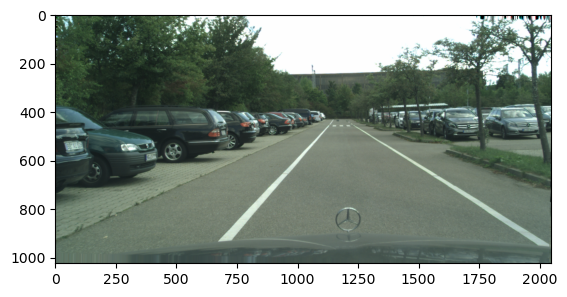

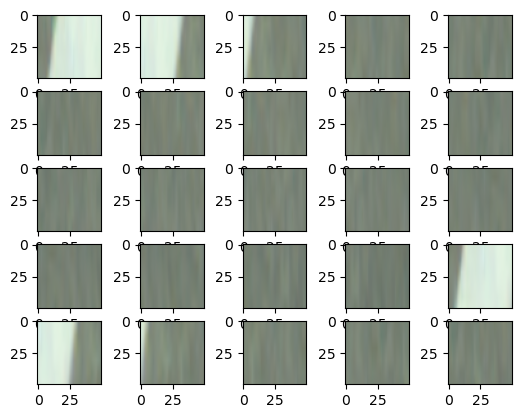

In [398]:
for img, patches in zip(train_ds['image'], x_train):
    _ = plt.figure()
    plt.imshow(img / 255.0)
    show_patches(patches, n=5)
    break

### Utility functions

In [407]:
def plot_fn(loss, xlabel=None, ylabel=None):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(loss)
    plt.show()


def show_image_x2(x1, x2, title1=None, title2=None):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title(title1)
    ax1.imshow(x1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title(title2)
    ax2.imshow(x2)


def show_image_x3(x1, x2, x3, title1=None, title2=None, title3=None):
    fig = plt.figure(figsize=(15, 30))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title(title1)
    ax1.imshow(x1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title(title2)
    ax2.imshow(x2)
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_title(title3)
    ax3.imshow(x3)


def normalize_image(img):
    img = img.astype(np.float32)
    min = np.amin(img)
    max = np.amax(img)
    return (img - min) / (max - min)

# Build the model

In [612]:
class RBM:
    def __init__(self, P, H, k=1, W=None, hb=None, vb=None):
        """
        nv = nr of units in the visible layer = P * P * 3

        nh = nr of units in the hidden layer = H

        :param P: patch size
        :param H: hidden layer size
        :param W: (optional) initial weights
        :param hb: (optional) initial hidden layer's bias
        :param vb: (optional) initial visible layer's bias
        :param k: (optional) nr of iterations in Gibbs sampling
        """
        self.patch_size = P
        self.nv = P * P * 3
        self.nh = H
        self.k = k

        # initialize the weight matrix with uniform gaussian prob distribution
        self.W = W if W is not None else tf.Variable(tf.random.normal([self.nv, self.nh]))
        # bias for hidden layer (initialized with 0)
        self.hb = hb if hb is not None else tf.Variable(np.zeros(self.nh).astype(np.float32))
        # bias for visible layer (initialized with 0)
        self.vb = vb if vb is not None else tf.Variable(np.zeros(self.nv).astype(np.float32))

    def forward_pass(self, v):
        """
         forward pass: compute a sample hidden activation vector (h)
         input: flattened image vector
         output: probability of obtaining the input configuration
        """
        h = tf.matmul(v, self.W) + self.hb
        return tf.nn.sigmoid(h)

    def backward_pass(self, h):
        """
         backward pass: compute a sample visible activation vector (v)
         input: probability of obtaining the input configuration (activation of the visible layer)
         output: reconstructed input configuration
        """
        return tf.matmul(h, self.W, transpose_b=True) + self.vb

    def one_pass(self, v0):
        """
        :param v0: flattened input image (with normalized values)
        :return: the reconstructed input

        Perform a forward and a backward pass to obtain the reconstructed input
        """
        h = self.forward_pass(v0)
        v1 = self.backward_pass(h)
        return v1

    def gibbs_sampling(self, v):
        v0 = v
        for i in range(self.k):
            h0 = self.forward_pass(v0)
            v0 = self.backward_pass(h0)
        return h0, v0

    def contrastive_divergence(self, v0, h0, v1, h1, lr):
        # v1 = self.bernoulli(v1)
        # positive weight gradient
        w_pos_grad = tf.matmul(v0, h0, transpose_a=True)
        # negative weight gradient
        w_neg_grad = tf.matmul(v1, h1, transpose_a=True)
        # compute the difference between these 2 gradients
        cd = tf.reduce_mean(w_pos_grad - w_neg_grad, 0)
        # update weights using CD
        self.W = self.W + lr * cd
        # update the biases
        self.vb = self.vb + lr * tf.reduce_sum(v0 - v1, 0)
        self.hb = self.hb + lr * tf.reduce_sum(h0 - h1, 0)

    def mean_squared_error(self, v0, v1):
        return tf.reduce_mean(tf.square(v0 - v1))

    def cross_entropy_loss(self, x, x1):
        # calculate the cross-entropy loss
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x1))

    def bernoulli(self, p):
        return tf.nn.relu(tf.sign(p - tf.random.uniform(tf.shape(p))))

    def reconstruction_error(self, v0, v1):
        """
        The smaller the reconstruction error of data is at the points with more probability distribution of training sample
        """
        loss = tf.math.abs(v0 - v1)
        loss = tf.math.multiply(loss, self.bernoulli(v1))
        return tf.reduce_sum(loss)

    def free_energy_gap(self, v):
        """
        Free energy is the energy that a single configuration would need in order to
        have the same probability as all configurations containing v.
        """
        # transform the visible bias to a column vector
        b = tf.reshape(self.vb, (self.nv, 1))
        visible_term = tf.matmul(v, b)
        # transform the result of the matrix multiplication back to a row vector
        visible_term = tf.reshape(visible_term, (1, -1))

        hidden_term = tf.nn.softplus(tf.matmul(v, self.W) + self.hb)
        hidden_term = tf.reduce_sum(hidden_term, axis=1)

        return tf.reduce_mean(- visible_term - hidden_term, axis=0)

    def energy_loss(self, v0, v1):
        """
        Log-likelihood = approximation of the reconstructed data to the original data distribution
        """
        # calculate the difference between the energy values of v0 (original) and v1 (reconstructed) input
        v1 = self.bernoulli(v1)
        loss = tf.math.abs(self.free_energy_gap(v0) - self.free_energy_gap(v1))
        return loss

    def update(self, v0, lr, loss_fn):
        """
        SGD optimizer is used to find the optimal weights which minimize the energy function.

        :param x: input vector to the visible layer
        :param lr: learning rate
        :param loss_fn: the loss function to be used. Can be one of 'mean-squared-error', 'contrastive-divergence','cross-entropy-loss','free-energy-gap'
        :return: the computed loss value
        """

        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

        with tf.GradientTape() as tape:
            tape.watch([self.W, self.hb, self.vb])
            # Gibbs sampling
            h0, v1 = self.gibbs_sampling(v0)
            h1 = self.forward_pass(v1)

            if loss_fn == 'contrastive-divergence':
                loss = self.reconstruction_error(v0, v1)
            if loss_fn == 'mean-squared-error':
                loss = self.mean_squared_error(v0, v1)
            elif loss_fn == 'cross-entropy-loss':
                loss = self.cross_entropy_loss(v0, v1)
            elif loss_fn == 'free-energy-gap':
                loss = self.energy_loss(v0, v1)

        if loss_fn == 'contrastive-divergence':
            # update weights and biases to minimize loss
            self.contrastive_divergence(v0, h0, v1, h1, lr)
        else:
            # minimize the loss function by calculating the gradient and updating the list of variables
            optimizer.minimize(loss, var_list=[self.W, self.hb, self.vb], tape=tape)

        return loss.numpy()

    def augment_image(self, img):
        # extract a smaller patch
        img = tf.image.random_crop(img, (self.patch_size, self.patch_size, 3))
        # flatten the pixels
        img = tf.reshape(img, [-1, self.nv])
        return img

    def fit(self, x, lr=0.001, epochs=15, loss_fn='mean-squared-error', patience=2, error_limit=1e-2):
        """
        Run gradient descent to find the optimal hyper-parameters for the model.

        :param x: training data
        :param lr: learning rate
        :param epochs: nr of epochs to be trained on
        :param error_limit: the min change in the error
        :param patience: the nr of epochs to wait before stopping if the loss doesn't change
        :return: the train error
        """
        training_loss = []
        prev_loss = 0
        patience_cnt = 0

        for epoch in range(0, epochs):
            loss_per_epoch = 0
            s = 0
            # shuffle the elements
            x = x.shuffle(1000)
            for instance in x:
                for patch in instance:
                    x0 = self.augment_image(patch)
                    # update the weight matrix and the visible bias & hidden bias
                    loss = self.update(x0, lr=lr, loss_fn=loss_fn)
                    loss_per_epoch += loss
                    s += 1

            loss_per_epoch /= s
            print('Epoch: ', epoch, ', train loss:', loss_per_epoch)

            if np.abs(loss_per_epoch - prev_loss) <= error_limit:
                patience_cnt += 1
                if patience_cnt > patience:
                    print("Early stop!")
                    break

            prev_loss = loss_per_epoch
            training_loss.append(loss_per_epoch)

        history = np.asarray(training_loss)
        return history, history.mean()

    def reconstruct(self, v0):
        """
        Represent a forward & backward pass through the network.
        Return the reconstructed image based on the previously learned weights.
        The input image is a 3D array, and the output preserves the shape of the input.
        """
        original_shape = v0.shape
        # reshape the input
        v0 = tf.reshape(v0, [-1, self.nv])
        # initial hidden prob vector based on the input v0
        v1 = self.one_pass(v0)
        # convert the output to the input's original shape
        v1 = tf.reshape(v1, original_shape)
        return v1

    def fill_texture(self, texture, img_height, img_width):
        multiples = [img_height // self.patch_size, img_width // self.patch_size, 1]
        img_texture = tf.tile(texture, multiples=multiples)
        return img_texture

    def generate_heatmap(self, reconstructed_patches, image, road_mask, file_name):
        # reconstruct the input image patches from the generated textures
        img_height, img_width, _ = image.shape
        reconstructed_patches = reconstructed_patches.reshape([-1, self.patch_size, self.patch_size, 3])
        reconstructed_image = feature_extraction.image.reconstruct_from_patches_2d(reconstructed_patches,
                                                                                   (img_height, img_width, 3))
        reconstructed_image = normalize_image(reconstructed_image)
        (score, heatmap) = structural_similarity(image, reconstructed_image, channel_axis=2, full=True)
        save_img(heatmap * 255.0, "output/heatmaps/original/" + file_name)
        # convert heatmap to grayscale image
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
        # remap the result from [0, mean] to [0, 1] to saturate the areas with noise
        # background is black, obstacles are white
        _, heatmap = cv2.threshold(heatmap, np.mean(heatmap), 1.0, cv2.THRESH_BINARY)
        # save the generated heatmap
        save_img(heatmap * 255.0, "output/heatmaps/binary/" + file_name)
        heatmap = heatmap.reshape([img_height, img_width, 1])
        # remove the detected pixels from the heatmap that are not part of the road area
        heatmap = heatmap * road_mask
        save_img(heatmap * 255.0, "output/heatmaps/road/" + file_name)
        return heatmap

    def detection_metrics(self, mask, heatmap):
        # background is black and the road surface has been excluded from the mask, leaving only the obstacle pixels (white)
        ap = np.count_nonzero(mask)
        if ap == 0:
            return 0, 0

        common = mask * heatmap
        cdp = np.count_nonzero(common)
        idp = np.count_nonzero(heatmap - common)
        # Pixel-wise Detection Rate
        pdr = cdp / ap
        # Pixel-wise False-Positive Rate
        pfpr = idp / ap

        return pdr, pfpr

    def evaluation_metrics(self, x0, x1):
        img_0 = tf.reshape(x0, [self.patch_size, self.patch_size, 3]).numpy()
        img_1 = tf.reshape(x1, [self.patch_size, self.patch_size, 3]).numpy()
        mse_score = mean_squared_error(img_0, img_1)
        ssim_score = structural_similarity(img_0, img_1, channel_axis=2)

        return mse_score, ssim_score

    def evaluate_reconstruction(self, x):
        """
        Evaluate the performance of the model, how well it can reconstruct the input texture, by computing the mean squared error and the mean structural similarity score between the reconstructed and the input patches.

        :param x: test set
        :return:
          - MSE: Encodes the quality of the pixels reconstructed by the RBM
          - SSIM: Analyses the image structure comparing the quality between the original and reconstructed image
        """
        mse_scores = []
        ssim_scores = []
        computation_time = 0

        nr_patches, img_height, img_width, _ = x_test.element_spec.shape
        results = []
        for instance in x:
            for patch in instance:
                x0 = self.augment_image(patch)
                start = time.time()
                x1 = self.one_pass(x0)
                end = time.time()
                computation_time += end - start
                results.append(x1.numpy())
                # compute the evaluation scores
                mse, ssim = self.evaluation_metrics(x0, x1)
                mse_scores.append(mse)
                ssim_scores.append(ssim)

        mse_scores = np.asarray(mse_scores)
        ssim_scores = np.asarray(ssim_scores)

        return {'mse': mse_scores.mean(), 'ssim': ssim_scores.mean(), 'time': computation_time / nr_patches,
                'reconstructed_patches': np.asarray(results).reshape(
                    [-1, nr_patches, self.patch_size, self.patch_size, 3])}

    def evaluate_detection(self, patches, images, masks, road_masks):
        """
        Compute the ratio of correctly detected pixels as obstacles with respect to the given mask.

        :param patches: the reconstructed patches
        :param images: the original input images
        :param masks: the segmentation masks which indicate obstacles
        :param road_masks: the segmentation masks which indicate the road areas
        :return:
         - PDR (Pixel-wise Detection Rate) - ratio between the correctly detected pixels as obstacles and the actual number of pixels belonging to obstacles
         - PFPR (Pixel-wise False-Positive Rate) - ratio between the nr of incorrectly detected pixels as obstacles and the actual number of pixels belonging to obstacles
        """
        pdr_scores = []
        pfpr_scores = []
        heatmaps = []
        computation_time = 0
        i = 0
        for (reconstructed_patches, image, mask, road_mask) in zip(patches, images, masks, road_masks):
            start = time.time()
            heatmap = self.generate_heatmap(reconstructed_patches, image.numpy(), road_mask.numpy(),
                                            file_name="test_{}.jpg".format(i))
            end = time.time()
            computation_time += end - start
            heatmaps.append(heatmap)
            pdr, pfpr = self.detection_metrics(mask.numpy(), heatmap)
            pdr_scores.append(pdr)
            pfpr_scores.append(pfpr)
            i += 1

        pdr_scores = np.asarray(pdr_scores)
        pfpr_scores = np.asarray(pfpr_scores)

        return {'pdr': pdr_scores.mean(), 'pfpr': pfpr_scores.mean(), 'time': computation_time / i,
                'heatmaps': np.asarray(heatmaps)}


# Build and train the models

Train the models using the same input parameters, but fine-tune for the hyperparameters for optimal performance

In [614]:
def save_models(models, path):
    params = tf.data.Dataset.from_tensor_slices({
        'P': [m.patch_size for m in models],
        'H': [m.nh for m in models],
        'k': [m.k for m in models],
        'W': [m.W for m in models],
        'vb': [m.vb for m in models],
        'hb': [m.hb for m in models]
    }, name="params")
    tf.data.Dataset.save(params, path)
    print("Saved dataset configuration to file: ", path)


def load_models(path):
    params_ds = tf.data.Dataset.load(path)
    models = []
    for params in params_ds:
        models.append(RBM(P=params['P'], H=params['H'], k=params['k'], W=params['W'], vb=params['vb'], hb=params['hb']))
    return models

In [14]:
x_test.element_spec.shape

TensorShape([361, 50, 50, 3])

In [615]:
# types of loss functions
loss_functions = {'MSE': 'mean-squared-error', 'CD': 'contrastive-divergence', 'CRE': 'cross-entropy-loss',
                  'FE': 'free-energy-gap'}


def train_model(x, p, h, k=1, loss_fn=loss_functions['MSE'], lr=0.001, max_epochs=100, patience=3, error_limit=1e-4, filename="models/rbm/model_x"):
    """
    Train the model with the given parameters.

    :param x: train dataset
    :param p: select a smaller patch from the training instance, of size PxP
    :param h: hidden layer size
    :param k: nr of iterations in Gibbs sampling
    :param lr: learning rate
    :param loss_fn: the loss function to be used
    :param max_epochs: max nr of epochs to run
    :param patience: nr of epochs to wait before stopping if the loss doesn't improve
    :param error_limit: the min change in the loss to continue the training
    :return:
    """
    print("Build and train an RBM model with the params: ")
    print("- loss function: ", loss_fn)
    print("- epochs: ", max_epochs, ", patience: ", patience, ", error limit: ", error_limit)
    print("- P =", p, ", H =", h, ", k =", k, ", lr =", lr)

    # create the model
    rbm = RBM(P=p, H=h, k=k)
    # train it
    history, train_loss = rbm.fit(x,
                                  lr=lr,
                                  loss_fn=loss_fn,
                                  epochs=max_epochs,
                                  error_limit=error_limit,
                                  patience=patience)
    plot_fn(history)
    print("Average training loss: ", train_loss)
    save_models([rbm], filename)
    return rbm, train_loss


def fine_tune_model(x, ps, hs, ks, lrs, loss_fn, max_epochs, patience, error_limit, path):
    """
    Train the model on multiple sets of configurations to find the best one.

    :param x: train dataset
    :param ps: select a smaller patch from the training instance, of size PxP
    :param hs: hidden layer sizes
    :param ks: nr of iterations in Gibbs sampling
    :param lrs: learning rates
    :param loss_fn: the loss function to be used
    :param max_epochs: nr of maximal epochs to run
    :param patience: nr of epochs to wait before stopping if the loss doesn't improve
    :param error_limit: the min change in the loss to continue the training
    :param path: the dir where to save the models
    :return: The trained models as well as a table with the corresponding hyperparameter configurations used during training
    """
    best_model = None
    min_loss = None
    losses = []
    i = 1
    configs = np.array(np.meshgrid(ps, hs, ks, lrs)).T.reshape(-1, 4)

    for p, h, k, lr in configs:
        p = int(p)
        h = int(h)
        k = int(k)
        rbm, loss = train_model(x, p, h, k, lr, loss_fn, max_epochs, patience, error_limit)
        print("------------------------------------------------------")
        losses.append(loss)
        if min_loss is not None and loss < min_loss:
            min_loss = loss
            best_model = rbm
        i += 1

    if best_model is not None:
        # save the parameters of the best model
        save_models([best_model], path)
    # create a dataset with the param configuration and the obtained results
    columns = ['id', 'P', 'H', 'k', 'lr', 'loss']
    data = np.hstack(range(1, i), configs, losses)
    data = np.column_stack(configs, data)

    return best_model, pd.DataFrame(data=data, columns=columns)

## Evaluation Criteria

**Mean-squared Error (MSE)**: squared difference between the pixels of the original and reconstructed image

**Structural Similarity Index (SSIM)**: checks the image quality degradation, opposite to MSE, it looks for similarities between the pixel density values.

**Pixel-wise Detection Rate (PDR)**: ratio between the correctly detected pixels as obstacles (CDP) and the actual number of pixels belonging to obstacles (AP).
> PDR = CDP/AP

**Pixel-wise False-Positive Rate (PFPR)**: ratio between the nr of incorrectly detected pixels as obstacles (IDP) and the actual number of pixels belonging to obstacles (AP).
> PFPR = IDP/AP

In [568]:
NR_SAMPLES = 2
NR_PATCHES = 2


def reconstruct_samples(model, x, nr_samples):
    """
    Run the model on a few sample images to evaluate the reconstruction quality.

    :param x: the set of test images
    :param model: the selected model
    :param nr_samples: nr of test instances selected randomly from the test set
    :param nr_patches: nr of patches to be selected from each instance
    """
    s = 0
    for img in x:
        total = img.shape[0]
        rand_indices = np.random.choice(total, 1, replace=False)
        for i in rand_indices:
            patch = tf.image.random_crop(img[i], (model.patch_size, model.patch_size, 3))
            reconstructed_patch = model.reconstruct(patch).numpy()
            show_image_x2(patch, reconstructed_patch, title1='Input patch', title2='Reconstructed input patch')
        s += 1
        if s >= nr_samples:
            break


def evaluate_model(model, x, image_ds, mask_ds, road_mask_ds):
    # evaluate the model's performance to reconstruct the road surface on the test set and plot the metrics
    evaluation_results = model.evaluate_reconstruction(x)
    avg_mse = evaluation_results['mse']
    avg_ssim = evaluation_results['ssim']
    reconstruction_time = evaluation_results['time']
    reconstructed_patches = evaluation_results['reconstructed_patches']
    print("Reconstruction time/instance:", reconstruction_time, "s")
    print("MSE score:", avg_mse)
    print("SSIM score:", avg_ssim)

    # evaluate the model's performance to detect obstacle son the road and plot the metrics
    detection_results = model.evaluate_detection(reconstructed_patches, image_ds, mask_ds, road_mask_ds)
    avg_pdr = detection_results['pdr']
    avg_pfpr = detection_results['pfpr']
    heatmap_generation_time = detection_results['time']
    heatmaps = detection_results['heatmaps']
    print("Heatmap generation time/instance:", heatmap_generation_time, "s")
    print("PDR score:", avg_pdr)
    print("PFPR score:", avg_pfpr)

    return heatmaps


def show_detection_results(image_ds, mask_ds, heatmaps, nr_samples=3):
    image_ds = list(image_ds.as_numpy_iterator())
    mask_ds = list(mask_ds.as_numpy_iterator())
    rand_indices = np.random.choice(len(image_ds), nr_samples, replace=False)
    for i in rand_indices:
        image = image_ds[i]
        mask = mask_ds[i]
        color = np.full(image.shape, [0, 1, 0], dtype=np.float32).reshape(image.shape)
        true_obstacles = np.where(mask != 0, color, image)
        heatmap = heatmaps[i]
        heatmap = heatmap.reshape((image.shape[0], image.shape[1], 1))
        detected_obstacles = np.where(heatmap != 0, color, image)
        show_image_x3(image, true_obstacles, detected_obstacles, title1='Original', title2='Actual obstacles',
                      title3='Detected obstacles')
        save_img(detected_obstacles * 255, "output/detected_obstacles/detection_{}.jpg".format(i))


### A. Model trained with MSE loss

Build and train an RBM model with the params: 
- loss function:  mean-squared-error
- epochs:  100 , patience:  3 , error limit:  0.001
- P = 8 , H = 20 , k = 1 , lr = 0.01
Epoch:  0 , train loss: 0.3861133126463269
Epoch:  1 , train loss: 0.006059185395202838
Epoch:  2 , train loss: 0.005070979544663735
Epoch:  3 , train loss: 0.004869865452429594
Epoch:  4 , train loss: 0.004431746172094425
Epoch:  5 , train loss: 0.004068320470684785
Early stop!


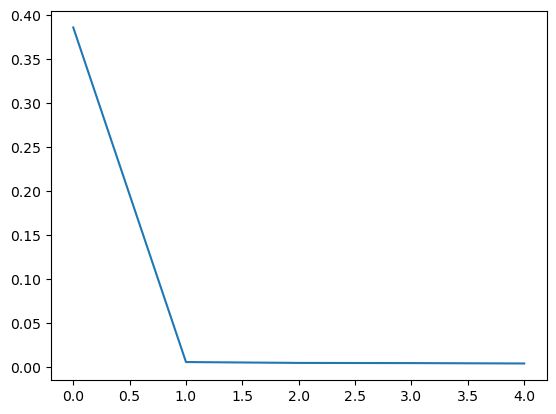

Average training loss:  0.08130901784214349
Saved dataset configuration to file:  models/rbm/mse


In [495]:
model_a, params_a = train_model(x=x_train,
                                p=8,
                                h=20,
                                k=1,
                                lr=0.01,
                                loss_fn=loss_functions['MSE'],
                                max_epochs=100,
                                patience=3,
                                error_limit=1e-3,
                                filename="models/rbm/model_a")

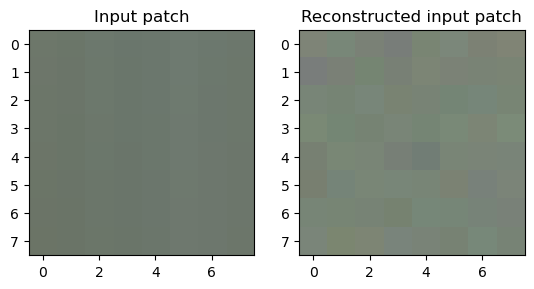

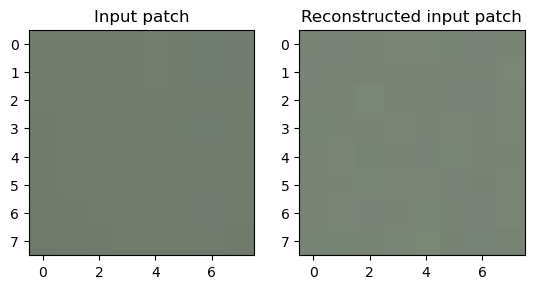

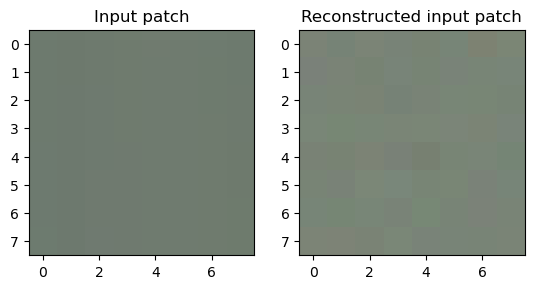

In [496]:
# display the result on a few test samples
reconstruct_samples(model_a, x_test, nr_samples=3)

In [497]:
# evaluate the model's performance on the test set
heatmaps_a = evaluate_model(model_a, x_test, x_test_images, x_test_mask, x_test_road_mask)

Reconstruction time/instance: 0.017262482577083512 s
MSE score: 0.004967585721943333
SSIM score: 0.8425743
Heatmap generation time/instance: 3.9544646441936493 s
PDR score: 0.48806668516687546
PFPR score: 7.549422339848936


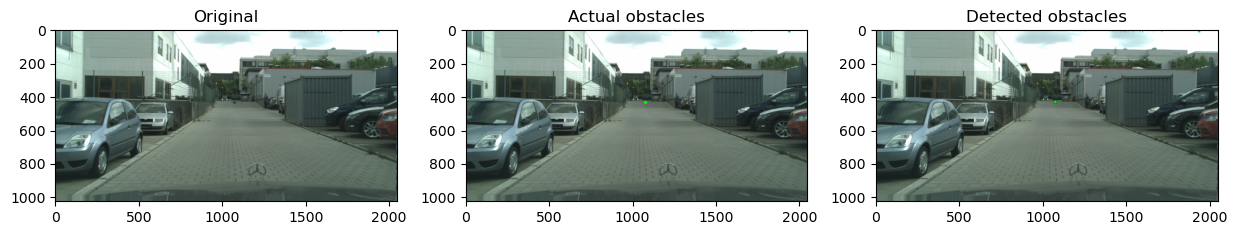

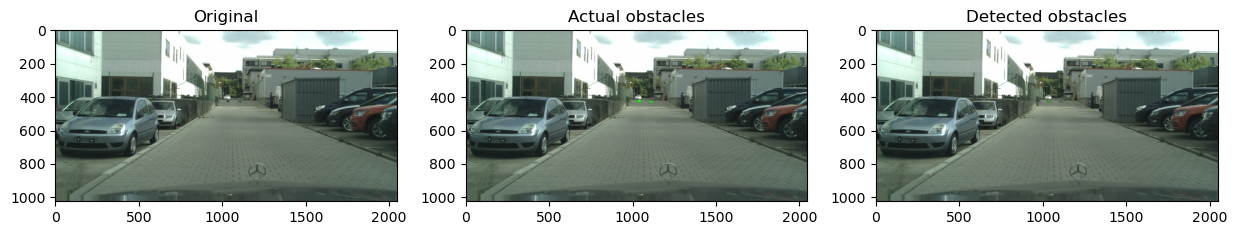

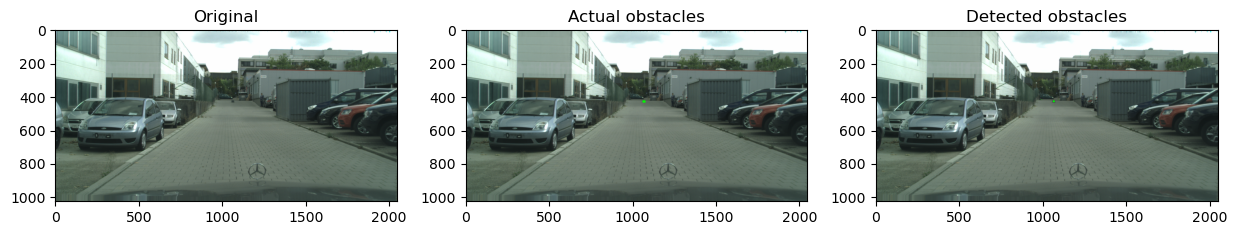

In [569]:
show_detection_results(x_test_images, x_test_mask, heatmaps_a)

Increase the size of the visible layer by selecting a larger patch size, P.

Build and train an RBM model with the params: 
- loss function:  mean-squared-error
- epochs:  100 , patience:  3 , error limit:  0.001
- P = 16 , H = 20 , k = 1 , lr = 0.01
Epoch:  0 , train loss: 1.2765214443413175
Epoch:  1 , train loss: 0.06949507997763392
Epoch:  2 , train loss: 0.010107980173798799
Epoch:  3 , train loss: 0.00600200335871085
Epoch:  4 , train loss: 0.005085957469265593
Epoch:  5 , train loss: 0.004553493517540829
Epoch:  6 , train loss: 0.004241896528615433
Epoch:  7 , train loss: 0.0041165346168576655
Early stop!


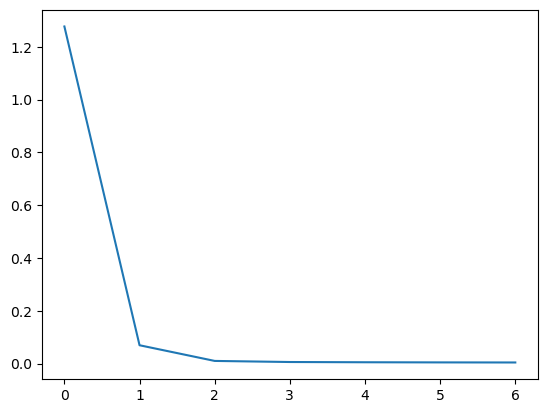

Average training loss:  0.1965725507666976
Saved dataset configuration to file:  models/rbm/model_a2


In [616]:
model_a2, params_a2 = train_model(x=x_train,
                                p=16,
                                h=20,
                                k=1,
                                lr=0.01,
                                loss_fn=loss_functions['MSE'],
                                max_epochs=100,
                                patience=3,
                                error_limit=1e-3,
                                filename="models/rbm/model_a2")

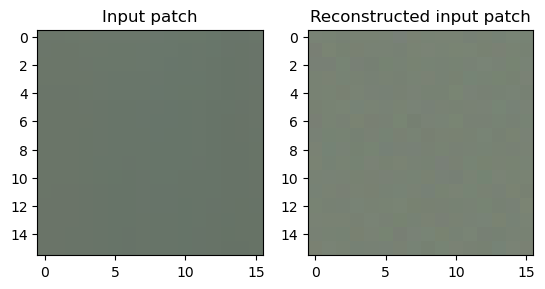

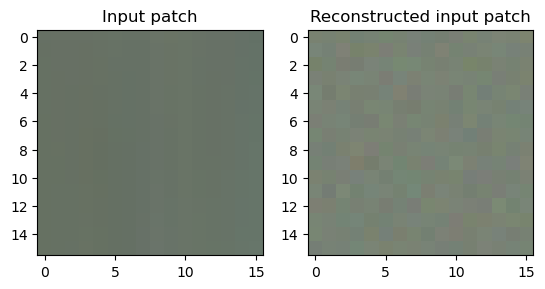

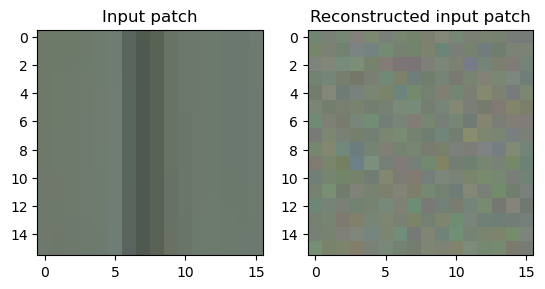

In [617]:
# display the result on a few test samples
reconstruct_samples(model_a2, x_test, nr_samples=3)

In [618]:
# evaluate the model's performance on the test set
heatmaps_a2 = evaluate_model(model_a2, x_test, x_test_images, x_test_mask, x_test_road_mask)

Reconstruction time/instance: 0.018034193324250197 s
MSE score: 0.003953459008758717
SSIM score: 0.87414163
Heatmap generation time/instance: 3.9493531957268715 s
PDR score: 0.46243965748872756
PFPR score: 1.566094444626244


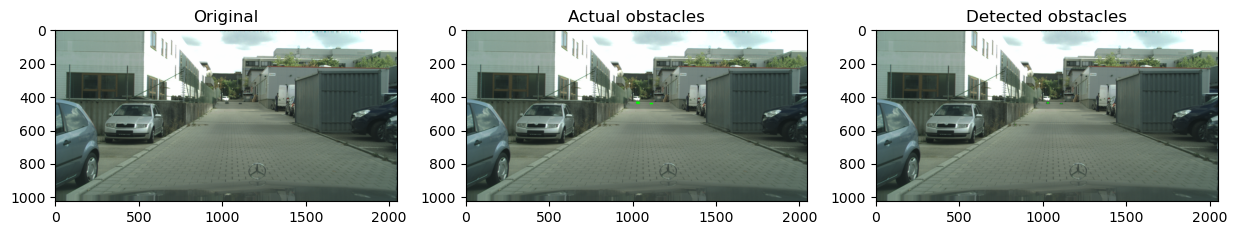

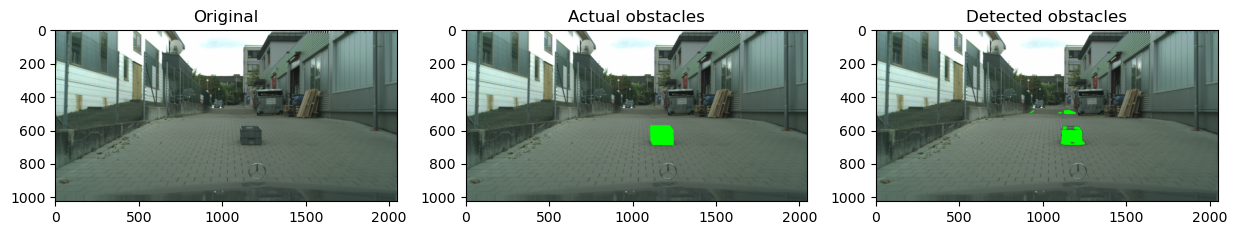

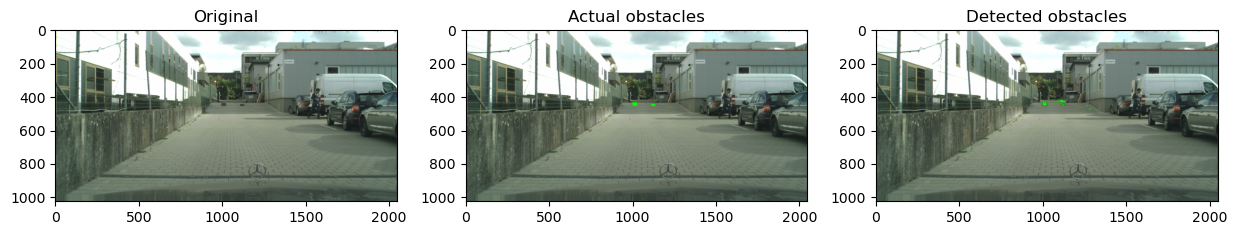

In [619]:
show_detection_results(x_test_images, x_test_mask, heatmaps_a2)

> Increasing the nr of units in the visible layer (x2) resulted in a smoother reconstruction, but it will increase the number of detected false positives.

### B. Model trained with energy loss

In [ ]:
model_b, params_b = train_model(x=x_train,
                                p=8,
                                h=20,
                                k=1,
                                lr=0.01,
                                loss_fn=loss_functions['FE'],
                                max_epochs=100,
                                patience=3,
                                error_limit=1e-3)

In [ ]:
# display the result on a few test samples
reconstruct_samples(model_b, x_test, nr_samples=3)

In [ ]:
# evaluate the model's performance on the test set
heatmaps_b = evaluate_model(model_b, x_test, x_test_images, x_test_mask, x_test_road_mask)

In [ ]:
show_detection_results(x_test_images, x_test_mask, heatmaps_b)

### C. Model trained with Contrastive Divergence algorithm and Gibbs sampling

In [ ]:
model_c, params_c = train_model(x=x_train,
                                p=8,
                                h=20,
                                k=1,
                                lr=0.01,
                                loss_fn=loss_functions['CD'],
                                max_epochs=100,
                                patience=3,
                                error_limit=1e-3)

In [ ]:
# display the result on a few test samples
reconstruct_samples(model_c, x_test, nr_samples=3)

In [ ]:
# evaluate the model's performance on the test set
heatmaps_c = evaluate_model(model_c, x_test, x_test_images, x_test_mask, x_test_road_mask)

In [ ]:
show_detection_results(x_test_images, x_test_mask, heatmaps_c)